## EFFICIENT NET

In [26]:
!pip install efficientnet-pytorch torch torchvision matplotlib


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16458 sha256=c1631fc8f54bcd759db01a387fdbc882e949ed88225009eedc14acb3e476057e
  Stored in directory: c:\users\ammar\appdata\local\pip\cache\wheels\03\3f\e9\911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\ammar/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100.0%


Loaded pretrained weights for efficientnet-b0
Epoch 1/10, Train Loss: 0.7079, Train Acc: 0.7581, Val Loss: 0.7019, Val Acc: 0.7523
Epoch 2/10, Train Loss: 0.5298, Train Acc: 0.8087, Val Loss: 0.5865, Val Acc: 0.7863
Epoch 3/10, Train Loss: 0.4479, Train Acc: 0.8377, Val Loss: 0.5161, Val Acc: 0.8289
Epoch 4/10, Train Loss: 0.3884, Train Acc: 0.8585, Val Loss: 0.5323, Val Acc: 0.8262
Epoch 5/10, Train Loss: 0.3540, Train Acc: 0.8715, Val Loss: 0.5576, Val Acc: 0.8049
Epoch 6/10, Train Loss: 0.3057, Train Acc: 0.8894, Val Loss: 0.5240, Val Acc: 0.8242
Epoch 7/10, Train Loss: 0.3007, Train Acc: 0.8929, Val Loss: 0.5403, Val Acc: 0.8495
Epoch 8/10, Train Loss: 0.2613, Train Acc: 0.9036, Val Loss: 0.4417, Val Acc: 0.8489
Epoch 9/10, Train Loss: 0.2327, Train Acc: 0.9153, Val Loss: 0.5817, Val Acc: 0.8469
Epoch 10/10, Train Loss: 0.2274, Train Acc: 0.9174, Val Loss: 0.5460, Val Acc: 0.8309


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

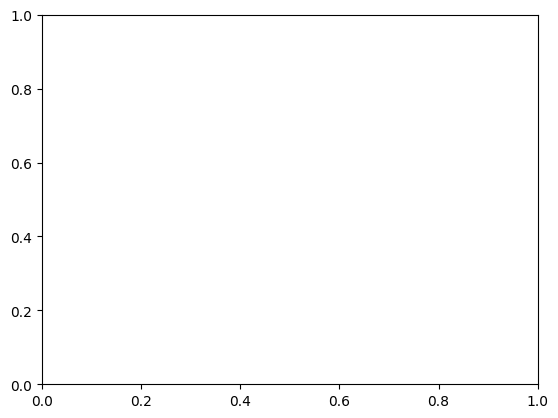

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np

# Define paths
data_path = r"C:\\Users\\ammar\\OneDrive\\Desktop\\DL_Skin\\HAM10000_metadata.csv"
image_folder = r"C:\\Users\\ammar\\OneDrive\\Desktop\\DL_Skin\\HAM10000_images_part_1"

# Load metadata
metadata = pd.read_csv(data_path)

# Map labels to indices
label_mapping = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'df': 5,
    'vasc': 6
}
metadata['label_idx'] = metadata['dx'].map(label_mapping)

# Split metadata into training, validation, and test sets
train_meta, temp_meta = train_test_split(metadata, test_size=0.3, random_state=42, stratify=metadata['label_idx'])
val_meta, test_meta = train_test_split(temp_meta, test_size=0.5, random_state=42, stratify=temp_meta['label_idx'])

# Image data loader class
class SkinCancerDataset(Dataset):
    def __init__(self, metadata, image_folder, transform=None):
        self.metadata = metadata
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f"{self.metadata.iloc[idx]['image_id']}.jpg")
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        label = self.metadata.iloc[idx]['label_idx']

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation and preprocessing for training and validation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = SkinCancerDataset(train_meta, image_folder, transform=train_transform)
val_dataset = SkinCancerDataset(val_meta, image_folder, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained EfficientNetB0 model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the final layer for 7 classes (output)
model._fc = nn.Linear(model._fc.in_features, 7)

# Set the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct / total

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the model if the validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

# Plot the training and validation loss
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## HYBRID MODEL WITH CNN

Loaded pretrained weights for efficientnet-b0
Epoch 1/10, Train Loss: 0.7623, Train Acc: 0.7358, Val Loss: 0.9864, Val Acc: 0.7443
Epoch 2/10, Train Loss: 0.5738, Train Acc: 0.8019, Val Loss: 0.6305, Val Acc: 0.7816
Epoch 3/10, Train Loss: 0.5000, Train Acc: 0.8230, Val Loss: 0.6390, Val Acc: 0.7863
Epoch 4/10, Train Loss: 0.4580, Train Acc: 0.8362, Val Loss: 0.6559, Val Acc: 0.7696
Epoch 5/10, Train Loss: 0.4098, Train Acc: 0.8522, Val Loss: 0.6086, Val Acc: 0.8162
Epoch 6/10, Train Loss: 0.3748, Train Acc: 0.8656, Val Loss: 0.5120, Val Acc: 0.8123
Epoch 7/10, Train Loss: 0.3361, Train Acc: 0.8809, Val Loss: 0.6949, Val Acc: 0.7889
Epoch 8/10, Train Loss: 0.3387, Train Acc: 0.8749, Val Loss: 0.4156, Val Acc: 0.8622
Epoch 9/10, Train Loss: 0.2984, Train Acc: 0.8924, Val Loss: 0.4409, Val Acc: 0.8455
Epoch 10/10, Train Loss: 0.2646, Train Acc: 0.9040, Val Loss: 0.5193, Val Acc: 0.8569


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

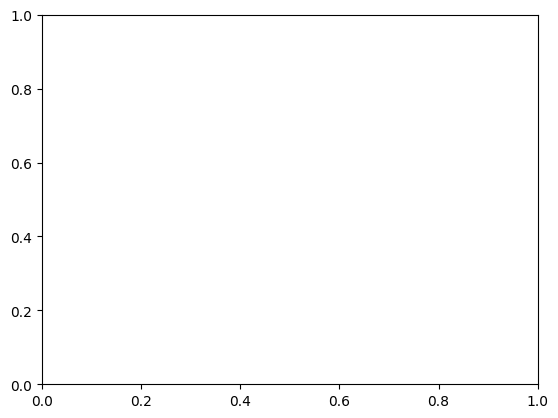

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define paths
data_path = r"C:\\Users\\ammar\\OneDrive\\Desktop\\DL_Skin\\HAM10000_metadata.csv"
image_folder = r"C:\\Users\\ammar\\OneDrive\\Desktop\\DL_Skin\\HAM10000_images_part_1"

# Load metadata
metadata = pd.read_csv(data_path)

# Map labels to indices
label_mapping = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'df': 5,
    'vasc': 6
}
metadata['label_idx'] = metadata['dx'].map(label_mapping)

# Split metadata into training, validation, and test sets
train_meta, temp_meta = train_test_split(metadata, test_size=0.3, random_state=42, stratify=metadata['label_idx'])
val_meta, test_meta = train_test_split(temp_meta, test_size=0.5, random_state=42, stratify=temp_meta['label_idx'])

# Image data loader class
class SkinCancerDataset(Dataset):
    def __init__(self, metadata, image_folder, transform=None):
        self.metadata = metadata
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f"{self.metadata.iloc[idx]['image_id']}.jpg")
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        label = self.metadata.iloc[idx]['label_idx']

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation and preprocessing for training and validation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = SkinCancerDataset(train_meta, image_folder, transform=train_transform)
val_dataset = SkinCancerDataset(val_meta, image_folder, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create a Hybrid Model by combining EfficientNetB0 and custom fully connected layers
class HybridModel(nn.Module):
    def __init__(self, num_classes=7):
        super(HybridModel, self).__init__()
        
        # Load pre-trained EfficientNetB0
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

        # Remove the classifier head (the last layer in EfficientNet)
        self.efficientnet._fc = nn.Identity()

        # Add custom layers after EfficientNet feature extraction
        self.fc1 = nn.Linear(1280, 512)  # 1280 is the output size of EfficientNetB0 feature extractor
        self.fc2 = nn.Linear(512, num_classes)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Pass through EfficientNetB0 (without the classification head)
        x = self.efficientnet(x)

        # Flatten the output from EfficientNet
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Instantiate the model
model = HybridModel(num_classes=7)

# Set the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct / total

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the model if the validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_hybrid_model.pth")

# Plot the training and validation loss
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
